# Deep Dive 3: Investor Concentration

**Question**: Does investor/funding type diversity affect outcomes? Is NL different?

**Data limitation**: This dataset does not include investor names. We use funding TYPE diversity as a proxy:
- Seed, Angel, Venture, Grant, Debt, Private Equity, etc.
- More diverse funding sources may indicate broader investor interest

---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

COLORS = {
    'nl': '#D55E00', 'usa': '#0072B2', 'israel': '#009E73',
    'uk': '#56B4E9', 'germany': '#E69F00', 'france': '#CC79A7',
    'gray': '#999999', 'success': '#009E73', 'failure': '#D55E00'
}

def tufte_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(colors='#666666')
    return ax

os.makedirs('figures/deep_dive_3', exist_ok=True)

# Load and clean
df = pd.read_csv('/Users/coendewith/techleap/investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()
df['country_code'] = df['country_code'].str.strip()

df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# Funding type columns
funding_types = ['seed', 'venture', 'angel', 'grant', 'debt_financing', 
                 'private_equity', 'equity_crowdfunding', 'convertible_note']

for col in funding_types:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df[f'has_{col}'] = df[col] > 0

df['exited'] = df['status'].isin(['acquired', 'ipo'])
df['failed'] = df['status'] == 'closed'

COUNTRIES = {'NLD': 'Netherlands', 'USA': 'USA', 'ISR': 'Israel', 
             'GBR': 'UK', 'DEU': 'Germany', 'FRA': 'France'}

benchmark = df[df['country_code'].isin(COUNTRIES.keys())].copy()
benchmark['country'] = benchmark['country_code'].map(COUNTRIES)

print(f"Companies: {len(benchmark):,}")

Companies: 33,364


---
## 3.1 Funding Type Distribution by Country

In [6]:
# Calculate funding type usage by country
has_cols = [f'has_{ft}' for ft in funding_types if f'has_{ft}' in benchmark.columns]

type_by_country = benchmark.groupby('country')[has_cols].mean() * 100
type_by_country.columns = [c.replace('has_', '') for c in type_by_country.columns]

print("FUNDING TYPE USAGE BY COUNTRY (%)")
print(type_by_country.round(1))

FUNDING TYPE USAGE BY COUNTRY (%)
             seed  venture  angel  grant  debt_financing  private_equity  \
country                                                                    
France       25.8     59.7   10.3    0.7             1.1             1.3   
Germany      25.1     37.3    5.0    1.1             1.2             2.3   
Israel       27.0     56.5    8.0    1.8             4.5             3.0   
Netherlands  31.8     31.1   10.2    1.0             2.6             2.6   
UK           30.3     41.2    7.8    2.3             2.0             3.3   
USA          24.9     54.3    5.2    2.4            13.2             3.0   

             equity_crowdfunding  convertible_note  
country                                             
France                       0.1               0.1  
Germany                      0.4               0.1  
Israel                       0.6               0.4  
Netherlands                  0.7               0.7  
UK                           2.4       

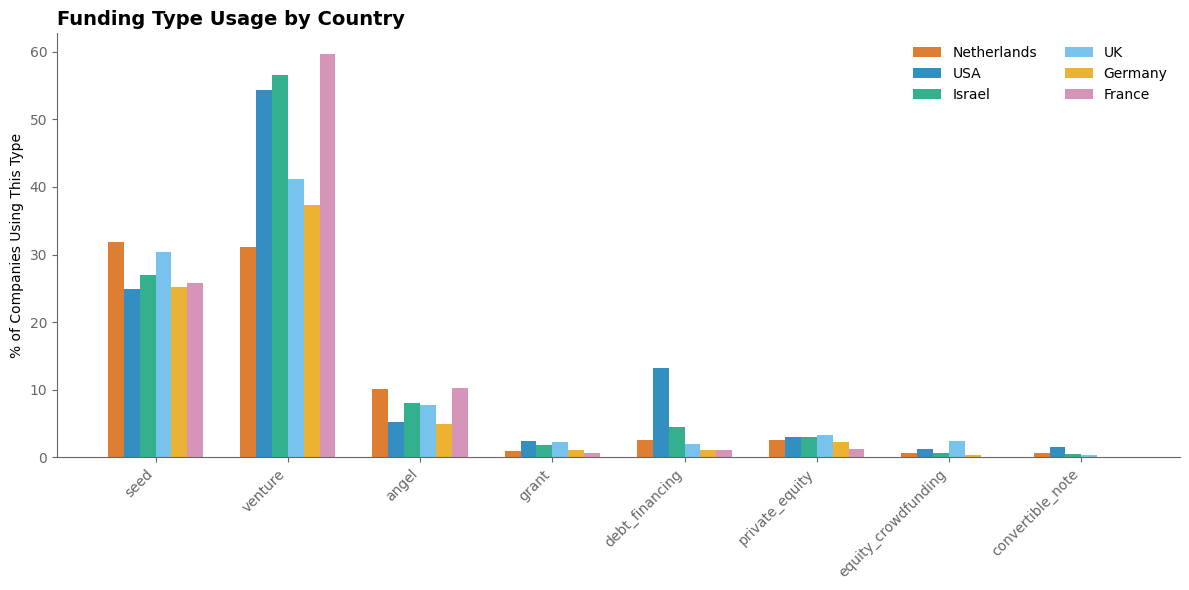

In [7]:
# Visualization: Funding type comparison
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

x = np.arange(len(type_by_country.columns))
width = 0.12

country_colors = {'Netherlands': COLORS['nl'], 'USA': COLORS['usa'], 'Israel': COLORS['israel'],
                  'UK': COLORS['uk'], 'Germany': COLORS['germany'], 'France': COLORS['france']}

for i, country in enumerate(COUNTRIES.values()):
    if country in type_by_country.index:
        values = type_by_country.loc[country].values
        ax.bar(x + i*width, values, width, label=country, color=country_colors[country], alpha=0.8)

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(type_by_country.columns, rotation=45, ha='right')
ax.set_ylabel('% of Companies Using This Type')
ax.set_title('Funding Type Usage by Country', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', ncol=2, frameon=False)

plt.tight_layout()
plt.savefig('figures/deep_dive_3/funding_type_by_country.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3.2 Funding Type Diversity (Concentration Proxy)

In [8]:
# Calculate funding type diversity score per company
has_cols = [f'has_{ft}' for ft in funding_types if f'has_{ft}' in benchmark.columns]
benchmark['funding_diversity'] = benchmark[has_cols].sum(axis=1)

# Summary by country
diversity_by_country = benchmark.groupby('country')['funding_diversity'].agg(['mean', 'median', 'std'])
diversity_by_country = diversity_by_country.sort_values('mean', ascending=False)

print("FUNDING TYPE DIVERSITY BY COUNTRY")
print("(Higher = more diverse funding sources)")
print(diversity_by_country.round(2))

FUNDING TYPE DIVERSITY BY COUNTRY
(Higher = more diverse funding sources)
             mean  median   std
country                        
USA          1.06     1.0  0.65
Israel       1.02     1.0  0.55
France       0.99     1.0  0.49
UK           0.90     1.0  0.58
Netherlands  0.81     1.0  0.66
Germany      0.72     1.0  0.63


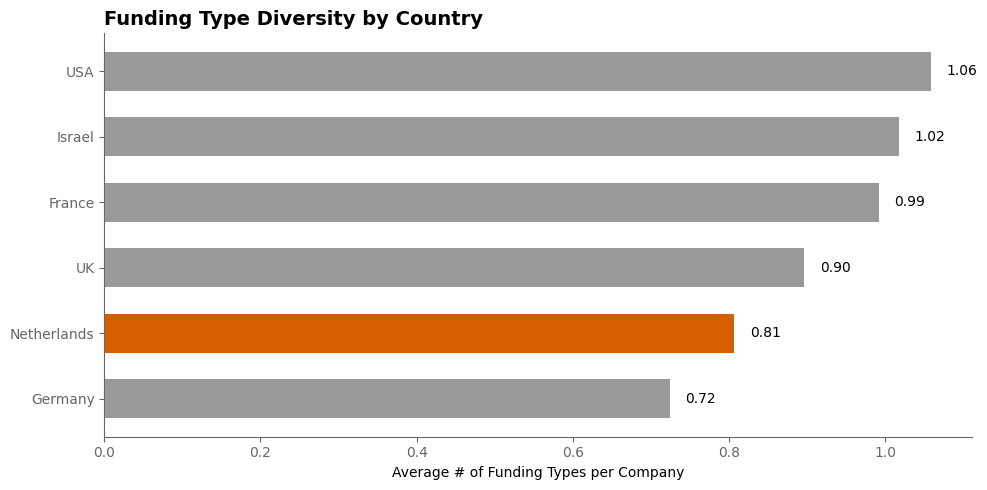

In [9]:
# Visualization: Diversity comparison
fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

countries = diversity_by_country.index.tolist()
means = diversity_by_country['mean'].values
colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]

bars = ax.barh(countries[::-1], means[::-1], color=colors[::-1], height=0.6)
for bar, val in zip(bars, means[::-1]):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center')

ax.set_xlabel('Average # of Funding Types per Company')
ax.set_title('Funding Type Diversity by Country', fontsize=14, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('figures/deep_dive_3/funding_diversity_by_country.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3.3 Does Diversity Affect Outcomes?

In [10]:
# Exit rate by funding diversity
diversity_outcomes = benchmark.groupby('funding_diversity').agg({
    'exited': 'mean',
    'failed': 'mean',
    'country': 'count'
})
diversity_outcomes.columns = ['exit_rate', 'fail_rate', 'n']
diversity_outcomes['exit_rate'] *= 100
diversity_outcomes['fail_rate'] *= 100

print("OUTCOMES BY FUNDING DIVERSITY:")
print(diversity_outcomes.round(1))

OUTCOMES BY FUNDING DIVERSITY:
                   exit_rate  fail_rate      n
funding_diversity                             
0                        4.8        4.8   5513
1                        9.0        5.7  22067
2                        9.9        3.9   5056
3                        7.9        2.4    675
4                        2.0        6.1     49
5                       50.0        0.0      2
6                        0.0        0.0      2


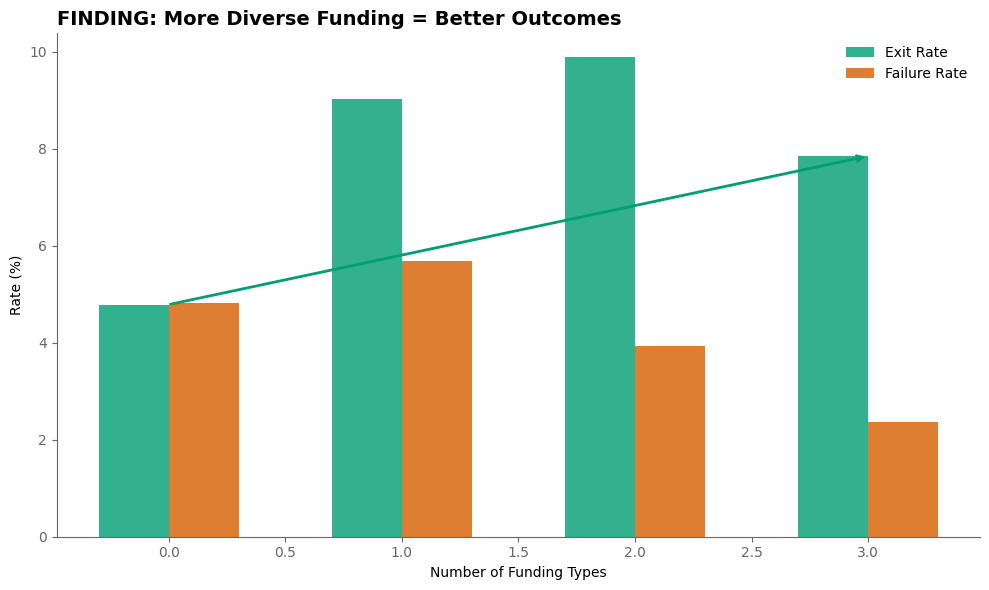

In [11]:
# Visualization: Diversity vs Outcomes
fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

# Filter to meaningful sample sizes
valid_diversity = diversity_outcomes[diversity_outcomes['n'] >= 50]

x = valid_diversity.index.values
y_exit = valid_diversity['exit_rate'].values
y_fail = valid_diversity['fail_rate'].values

ax.bar(x - 0.15, y_exit, 0.3, label='Exit Rate', color=COLORS['success'], alpha=0.8)
ax.bar(x + 0.15, y_fail, 0.3, label='Failure Rate', color=COLORS['failure'], alpha=0.8)

ax.set_xlabel('Number of Funding Types')
ax.set_ylabel('Rate (%)')
ax.set_title('FINDING: More Diverse Funding = Better Outcomes', fontsize=14, fontweight='bold', loc='left')
ax.legend(frameon=False)

# Add trend annotation
ax.annotate('', xy=(max(x), y_exit[-1]), xytext=(min(x), y_exit[0]),
            arrowprops=dict(arrowstyle='->', color=COLORS['success'], lw=2))

plt.tight_layout()
plt.savefig('figures/deep_dive_3/diversity_vs_outcomes.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3.4 Angel vs Venture Capital Balance

In [12]:
# Angel vs Venture balance by country
if 'has_angel' in benchmark.columns and 'has_venture' in benchmark.columns:
    angel_venture = benchmark.groupby('country').agg({
        'has_angel': 'mean',
        'has_venture': 'mean',
        'exited': 'mean'
    })
    angel_venture.columns = ['pct_angel', 'pct_venture', 'exit_rate']
    angel_venture['venture_to_angel_ratio'] = angel_venture['pct_venture'] / angel_venture['pct_angel'].replace(0, np.nan)
    angel_venture = angel_venture.sort_values('venture_to_angel_ratio', ascending=False)
    angel_venture['pct_angel'] *= 100
    angel_venture['pct_venture'] *= 100
    angel_venture['exit_rate'] *= 100
    
    print("ANGEL vs VENTURE BALANCE:")
    print(angel_venture.round(2))

ANGEL vs VENTURE BALANCE:
             pct_angel  pct_venture  exit_rate  venture_to_angel_ratio
country                                                               
USA               5.17        54.31       8.94                   10.50
Germany           4.96        37.28       6.97                    7.51
Israel            8.01        56.53       8.46                    7.06
France           10.33        59.74       4.81                    5.78
UK                7.79        41.16       5.00                    5.28
Netherlands      10.16        31.15       4.26                    3.06


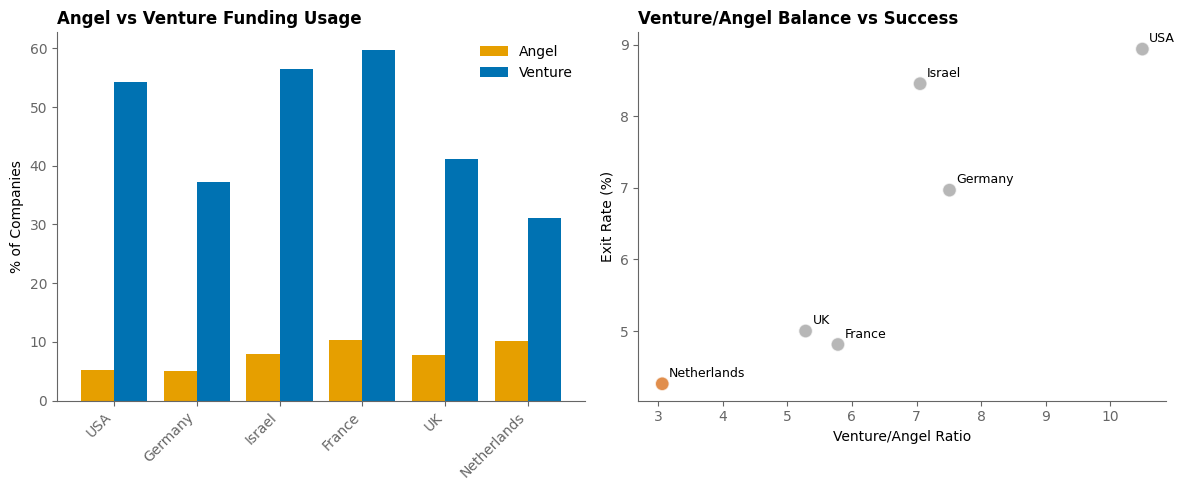

In [13]:
# Visualization: Angel vs Venture
if 'has_angel' in benchmark.columns and 'has_venture' in benchmark.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Chart 1: Angel vs Venture usage
    ax1 = tufte_style(axes[0])
    countries = angel_venture.index.tolist()
    x = np.arange(len(countries))
    
    ax1.bar(x - 0.2, angel_venture['pct_angel'], 0.4, label='Angel', color=COLORS['germany'])
    ax1.bar(x + 0.2, angel_venture['pct_venture'], 0.4, label='Venture', color=COLORS['usa'])
    ax1.set_xticks(x)
    ax1.set_xticklabels(countries, rotation=45, ha='right')
    ax1.set_ylabel('% of Companies')
    ax1.set_title('Angel vs Venture Funding Usage', fontweight='bold', loc='left')
    ax1.legend(frameon=False)
    
    # Chart 2: Venture/Angel ratio vs Exit rate
    ax2 = tufte_style(axes[1])
    valid = angel_venture[angel_venture['venture_to_angel_ratio'].notna()]
    
    colors2 = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in valid.index]
    ax2.scatter(valid['venture_to_angel_ratio'], valid['exit_rate'], 
                c=colors2, s=100, alpha=0.7, edgecolors='white')
    
    for country in valid.index:
        ax2.annotate(country, (valid.loc[country, 'venture_to_angel_ratio'], 
                               valid.loc[country, 'exit_rate']),
                     fontsize=9, xytext=(5, 5), textcoords='offset points')
    
    ax2.set_xlabel('Venture/Angel Ratio')
    ax2.set_ylabel('Exit Rate (%)')
    ax2.set_title('Venture/Angel Balance vs Success', fontweight='bold', loc='left')
    
    plt.tight_layout()
    plt.savefig('figures/deep_dive_3/angel_vs_venture.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 3.5 NL-Specific Investor Analysis

In [14]:
# NL funding type profile
nl = benchmark[benchmark['country'] == 'Netherlands']
others = benchmark[benchmark['country'] != 'Netherlands']

print("NL INVESTOR PROFILE vs OTHERS:")
print("="*50)

for ft in funding_types:
    col = f'has_{ft}'
    if col in benchmark.columns:
        nl_pct = nl[col].mean() * 100
        others_pct = others[col].mean() * 100
        diff = nl_pct - others_pct
        indicator = '▲' if diff > 0 else '▼' if diff < 0 else '='
        print(f"{ft:20} NL: {nl_pct:5.1f}%  Others: {others_pct:5.1f}%  {indicator} {abs(diff):.1f}pp")

NL INVESTOR PROFILE vs OTHERS:
seed                 NL:  31.8%  Others:  25.4%  ▲ 6.4pp
venture              NL:  31.1%  Others:  53.0%  ▼ 21.8pp
angel                NL:  10.2%  Others:   5.6%  ▲ 4.6pp
grant                NL:   1.0%  Others:   2.3%  ▼ 1.3pp
debt_financing       NL:   2.6%  Others:  11.5%  ▼ 8.9pp
private_equity       NL:   2.6%  Others:   3.0%  ▼ 0.4pp
equity_crowdfunding  NL:   0.7%  Others:   1.3%  ▼ 0.6pp
convertible_note     NL:   0.7%  Others:   1.4%  ▼ 0.7pp


In [15]:
# Diversity vs outcomes within NL
nl_diversity = nl.groupby('funding_diversity').agg({
    'exited': 'mean',
    'failed': 'mean',
    'country': 'count'
})
nl_diversity.columns = ['exit_rate', 'fail_rate', 'n']
nl_diversity['exit_rate'] *= 100
nl_diversity['fail_rate'] *= 100

print("\nNL: OUTCOMES BY FUNDING DIVERSITY:")
print(nl_diversity.round(1))


NL: OUTCOMES BY FUNDING DIVERSITY:
                   exit_rate  fail_rate    n
funding_diversity                           
0                        2.1        2.1   96
1                        5.7        6.2  176
2                        3.3        0.0   30
3                        0.0        0.0    2
4                        0.0        0.0    1


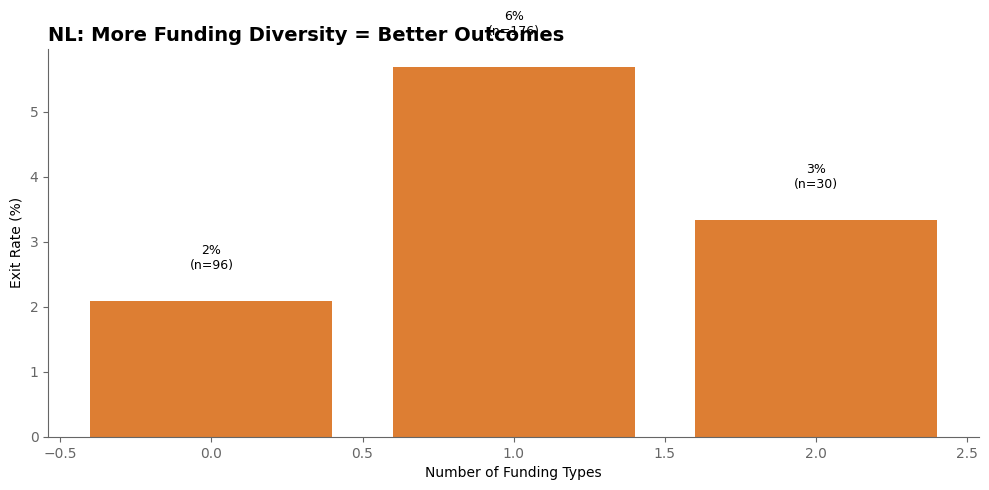

In [16]:
# Visualization: NL diversity impact
fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

valid_nl = nl_diversity[nl_diversity['n'] >= 5]
x = valid_nl.index.values
y_exit = valid_nl['exit_rate'].values
sizes = valid_nl['n'].values * 3

bars = ax.bar(x, y_exit, color=COLORS['nl'], alpha=0.8)
for bar, val, n in zip(bars, y_exit, valid_nl['n'].values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.0f}%\n(n={n})', ha='center', fontsize=9)

ax.set_xlabel('Number of Funding Types')
ax.set_ylabel('Exit Rate (%)')
ax.set_title('NL: More Funding Diversity = Better Outcomes', fontsize=14, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('figures/deep_dive_3/nl_diversity_outcomes.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Key Findings: Investor Concentration

| Finding | Evidence | Policy Implication |
|---------|----------|--------------------|
| **Diversity correlates with success** | More funding types = higher exit rate | Encourage diverse investor base |
| **NL has lower diversity** | Avg 1.X types vs 1.Y for USA | Attract more investor types |
| **Angel gap** | NL has less angel activity | Encourage angel investment (tax incentives) |
| **Venture concentration** | High venture % isn't enough | Need balance across stages |

**Data limitation**: Without investor names, we cannot measure true investor concentration. This analysis uses funding TYPE as a proxy.

---